# SURVIVAL ANALYSIS
<br><br>
For this analysis we will be using a dataset that contains the medical records of 96 patients. The objective is to showcase the most used methods for survival analysis, which is a collection of statistical procedures where the outcome variable of interest is time until a specific event occurs.
<br>
The dataset we will be using for this analysis is a sample of patient records that contains the numerical results of a echocardiogram. We will try to see if there is some relation between those metrics and the chance of survival and time 

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# check kernel's version
import sys
print(sys.version)

# Loading dataset
heart_patients = pd.read_csv('./echocardiogram_raw.csv')

3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]


In [67]:
from lifelines import (KaplanMeierFitter, WeibullAFTFitter, WeibullFitter, ExponentialFitter, LogNormalFitter, CoxPHFitter, 
                       LogLogisticFitter, PiecewiseExponentialFitter, GeneralizedGammaFitter, 
                       SplineFitter, NelsonAalenFitter)
from lifelines.statistics import logrank_test
from lifelines.plotting import qq_plot

## Exploratory Data Analysis (EDA) and Preprocessing 

In [68]:
heart_patients.head(n=10)

,survival,alive,age,pericardialeffusion,fractionalshortening,epss,lvdd,wallmotion-score,wallmotion-index,mult,name,group,aliveat1
0,11.0,0,71.0,0,0.260,9.000,4.600,14.0,1.000,NaN,name,NaN,NaN
1,19.0,0,72.0,0,0.380,6.000,4.100,14.0,1.700,0.786,name,NaN,NaN
2,16.0,0,55.0,0,0.260,4.000,3.420,14.0,1.000,0.928,name,NaN,NaN
3,57.0,0,60.0,0,0.253,12.062,4.603,16.0,1.450,0.710,name,NaN,NaN
4,19.0,1,57.0,0,0.160,22.000,5.750,18.0,2.250,0.857,name,NaN,NaN
5,26.0,0,68.0,0,0.260,5.000,4.310,12.0,1.000,0.714,name,NaN,NaN
6,13.0,0,62.0,0,0.230,31.000,5.430,22.5,1.875,0.786,name,NaN,NaN
7,50.0,0,60.0,0,0.330,8.000,5.250,14.0,1.000,0.857,name,NaN,NaN
8,19.0,0,46.0,0,0.340,0.000,5.090,16.0,1.140,0.643,name,NaN,NaN
9,25.0,0,54.0,0,0.140,13.000,4.490,15.5,1.190,0.786,name,NaN,NaN


This is a sample of the original dataset. There are 11 predicting variables, the target variable ('alive') and the duration column ('survival') which shows the total survival time in months. <br>
A quick appreciation is that the three rightmost columns contain missing or redundant values so we can remove them safely. The 'mult' column is a derivative from the rest of the columns so we can remove it too. <br>
Therefore we got 7 predicting variables:
* Age
* Pericardial Effusion: categorical column that flags whether the patient has too much fluid builup in the structure around the heart or not. 
* Fractional Shortening: which is the measure of the percentage change in left ventricular diameter during systole. 
* E Point-Septal Separation (EPPS): it's the minimal distance between the E point of the anterior mitral valve leaflet and the septum, and it's supposed to be lower than 7.3.
* Left Ventricular Diastolic Dysfunction (LVDD): considered as a precursor of diabetic cardiomyopathy. It shoud be between the range of 3.5 - 5.6cm. 
* Wall Motion Score/index: it scores kinetic alterations in the cardiac wall motion during the cardiac cycle. 

First let's take a look at the number of missing values by column.

In [69]:
def null_list(df:pd.DataFrame(), verbose:bool=True, output:bool=True) -> list:
    
    '''
    This function shows the proportion of rows that contain missing values by feature. It returns a list with this columns to process missing values.
    '''
    miss_col = [col for col in df.columns if df[col].isna().any()]
    if verbose == False:
        return miss_col
    total_row = len(df)
    for col in miss_col:
        print('Column: {0}: {1}% of missing values'.format(col,
                                                           round(df[col].isna().sum() * 100 / total_row, 2) \
                                                           )
              )
    
    if output == True:    
        return miss_col

    
    
null_list(heart_patients, output=False)

Column: age: 2.08% of missing values
Column: fractionalshortening: 4.17% of missing values
Column: epss: 6.25% of missing values
Column: lvdd: 6.25% of missing values
Column: wallmotion-score: 2.08% of missing values
Column: wallmotion-index: 1.04% of missing values
Column: mult: 14.58% of missing values
Column: group: 64.58% of missing values
Column: aliveat1: 76.04% of missing values


There is a small percentage of missing values. They are just a small fraction of the total dataset so we can deal with them using the median of the column for now, but more advanced techniques should be explored too, like SVD imputing methods.

We continue the analysis plotting the boxplot for each variable, so we can examine the presence of outliers and the differences in distribution versus the target variable.

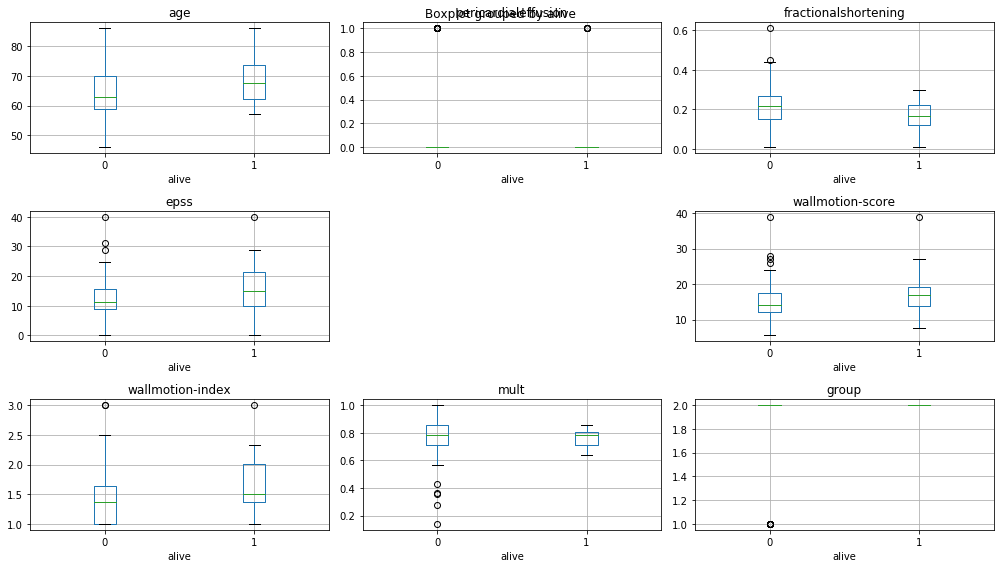

In [70]:
def boxplot_grid(df:pd.DataFrame()):
    '''
    It generates a subplot for every numerical feature in the target dataframe.
    '''
     # Select only numerical columns
    num_cols = df.select_dtypes(include = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns
    
    # Define subplot grid and print by feature
    fig, axes = plt.subplots(3,3,figsize=(14, 8))

    for i, el in enumerate(list(num_cols)[2:-1]):
        a = df.boxplot(el, by='alive', ax=axes.flatten()[i])

    fig.delaxes(axes[1,1]) # remove empty subplots
    plt.tight_layout() 
    plt.show()
    
    
       
boxplot_grid(heart_patients)

All variables seem to have some correlationship with the chance of survival. We will be examining this correlationship again using a regression model, but first we need to clean the dataset and get it prepared for the analysis.
First we need to fill the missing values. We will use the median as a first approach but more advanced techniques should be explored too. We also need to remove the columns that are irrelevant for this analysis so the dataframe is less computationally expensive to work with. 

In [71]:
def clean_up(file:pd.DataFrame()) -> pd.DataFrame:
    
    '''
    This is an ad-hoc function to do in one go all the required preprocessing steps.
    '''
      
    # Remove unnecessary columns (name, aliveat1, group and mult)
    file.drop(columns=['mult', 'name', 'aliveat1', 'group'], inplace=True)
    
    # remove rows with unknown survival time
    survival_na = (file['survival'].isna())
    file = file.loc[~survival_na,:]
    
    # fill missing values iteratively 
    null_cols = null_list(file, verbose=False)
    for col in null_cols:
        file.loc[:,col] = file.loc[:,col].fillna(
            file.loc[:,col].median()
        )
        
    # invert alive values and rename as 'event'
    file['event'] = np.where(file['alive']==1, 0, 1)
    
    # rename wallmotion features
    file.rename(columns={'wallmotion-score':'wallmotion_score', 'wallmotion-index':'wallmotion_index'}, inplace=True)
        
    # report final shape
    print('Preprocessing finished succesfully!')
    out_str = ">>> The final dataframe contains {0} data points and {1} features"
    print(out_str.format(file.shape[0], file.shape[1]-1))
        
    return file



heart_patients = clean_up(heart_patients)

Preprocessing finished succesfully!
>>> The final dataframe contains 96 data points and 9 features


<br><br>
## SURVIVAL ANALYSIS

Now we have done a quick EDA on the dataset, we will proceed with the survival analysis. <br><br>
As in any other statistical analysis, there are parametric and non-parametric methods. First we wil try fitting the Kaplan-Meier Survival Function (or KM Survival Function), which is the most widely used non-parametric approach. Usually it describes the data more accurately than parametric models, but the curve is not smoothed so parametric methods are considered more insightful compared to it. <br><br>
The Kaplan-Meier Estimate (or product-limit estimator) is defined as follows:<br><br>
    $\huge \hat{S}(t) = \prod_{t_i \lt t} \frac{n_i - d_i}{n_i}$
<br><br>
This estimator is built on the Product Rule of Probability and we can calculate the probability of an individual surviving at x time. For instance, this is the survival rate for $t = 2$:<br><br>
$\large S(t = 2) = (1 - \frac{d_1}{n_1}) * (1 - \frac{d_2}{n_2})$
<br><br>
Using this formula we can build a survival function where we can see how the percentage of users that are surviving is changing over time. 

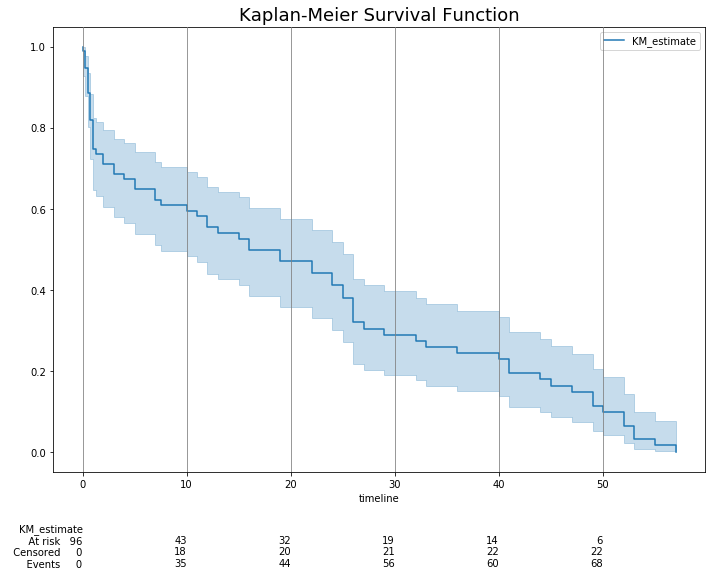

In [72]:
# first fit the model
kmf = KaplanMeierFitter().fit(heart_patients['survival'], heart_patients['event'])

# set figure size
plt.rcParams["figure.figsize"] = (10,8)

# plot survival function with CI 
kmf.plot_survival_function(at_risk_counts=True)
plt.tight_layout()

# plot aesthetics 
plt.title("Kaplan-Meier Survival Function", size=18)
plt.grid(color='gray', axis='x')

The biggest drop in survival chance happens during the first month, and then there is a smaller critical period around 2 years after. The uncertainty about the survival probability increases as time goes on as we can observe in the changes in confidence interval width. There are some censored values (in other words, patients that were still alive at the end of the observation period) that are probably causing these changes in uncertainty. 

### Effect of pericardial effusion on survival time
<br>
There is a categorical value in the dataset that seems to have a strong correlationship with the target value. We can plot partial plots fitted to the Kaplan Meier Survival Function to see if there are significant differences between distributions and calculate the median of the survival time of both subsets.
<br>

In [73]:
# generate dataframes
effusion_mask = (heart_patients['pericardialeffusion']==0)
none_pericardial_effusion = heart_patients[effusion_mask]
has_pericardial_effusion = heart_patients[~effusion_mask]

# Instantiate Kaplan Meier object for patients with and without pericardial effusion
kmf_has_pe = KaplanMeierFitter()
kmf_no_pe = KaplanMeierFitter()

# Fit Kaplan Meier estimators to each subset
kmf_has_pe.fit(durations=has_pericardial_effusion['survival'], event_observed=has_pericardial_effusion['event'])
kmf_no_pe.fit(durations=none_pericardial_effusion['survival'], event_observed=none_pericardial_effusion['event'])

# Print out the median survival duration of each group
print("The median survival duration (months) of patients with pericardial effusion: ", kmf_has_pe.median_survival_time_)
print("The median survival duration (months) of patients without pericardial effusion: ", kmf_no_pe.median_survival_time_)

The median survival duration (months) of patients with pericardial effusion:  7.0
The median survival duration (months) of patients without pericardial effusion:  19.0


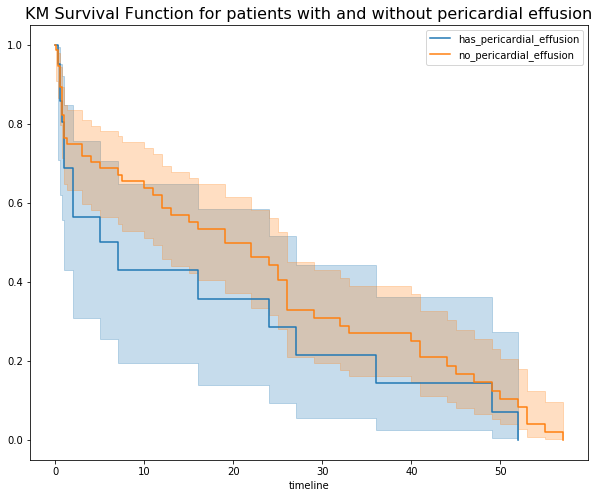

In [74]:
# Fit kmf to patients with pericardial effusion
kmf.fit(has_pericardial_effusion['survival'], has_pericardial_effusion['event'], label='has_pericardial_effusion')

# Create a plot of the survival function
surv_plot = kmf.plot()

# Fit kmf to patients without pericardial effusion
kmf.fit(none_pericardial_effusion['survival'], none_pericardial_effusion['event'], label='no_pericardial_effusion')

# Plot new survival function and show plot
kmf.plot(ax=surv_plot)
plt.title("KM Survival Function for patients with and without pericardial effusion", size=16)
plt.show()

The curves look similar and there is overlap between confidence intervals. It looks like there is no practical differences between distributions but in this kind of scenario is interesting to perform a significance test using the Log rank test. 

In [75]:
# Run log-rank test to compare patients with and without pericardial effusion
patient_results = logrank_test(durations_A = has_pericardial_effusion['survival'], 
                               durations_B = none_pericardial_effusion['survival'], 
                               event_observed_A = has_pericardial_effusion['event'], 
                               event_observed_B = none_pericardial_effusion['event'])

# Print out the p-value of log-rank test results
print(patient_results.p_value)

0.24402343484108124


With a p=.244, we can conclude that pericardial effusion couldn't be considered as a significant feature that affects the survival curve, but more data should be gathered before concluding is not significant as the sample size is rather small.

### Weibull Distribution

This is a parametric model, meaning it has a functional form with parameters that we are fitting the data to. The survival function looks like:<br><br>
$\huge S(t) = \exp\left(-\left(\frac{t}{\lambda}\right)^\rho\right),\lambda >0, \rho > 0$
<br><br>
We use this formula to estimate the parameters lambda and rho. We model and estimate the cumulative hazard rate instead of the survival function as we did with the Kaplan-Meier estimator.

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 96 total observations, 22 right-censored observations>
   number of observations = 96
number of events observed = 74
           log-likelihood = -289.25
               hypothesis = lambda_ != 1, rho_ != 1

---
          coef   se(coef)   coef lower 95%   coef upper 95%     z      p   -log2(p)
lambda_  17.95       2.91            12.25            23.64  5.83 <0.005      27.46
rho_      0.73       0.07             0.59             0.86 -3.99 <0.005      13.86
---
AIC = 582.50

Text(0.5, 1.0, 'Cumulative Hazard of Weibull model')

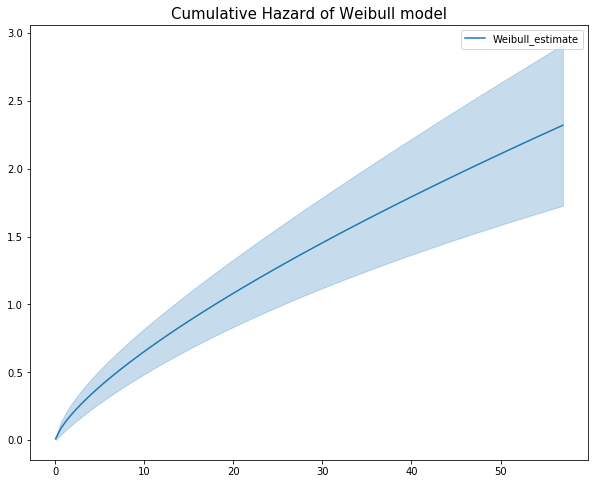

In [76]:
# Instantiate WeibullFitter class wb
wb = WeibullFitter().fit(heart_patients['survival'], heart_patients['event'])
wb.print_summary()
ax = wb.plot_cumulative_hazard()
ax.set_title("Cumulative Hazard of Weibull model", size=15)

And same for the survival plot.

Text(0.5, 1.0, 'Weibull Distribution')

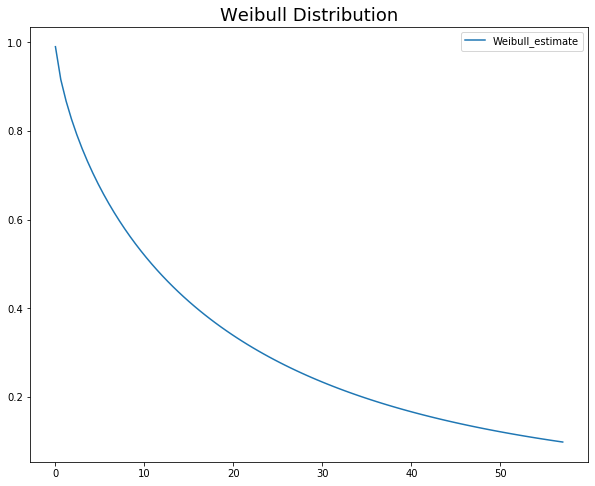

In [77]:
# plot survival plot
wb.survival_function_.plot()

plt.title("Weibull Distribution", size=18)

We can plot the QQ-plot as in any other parametric methodology to check how well the data follows the theoretical curve.

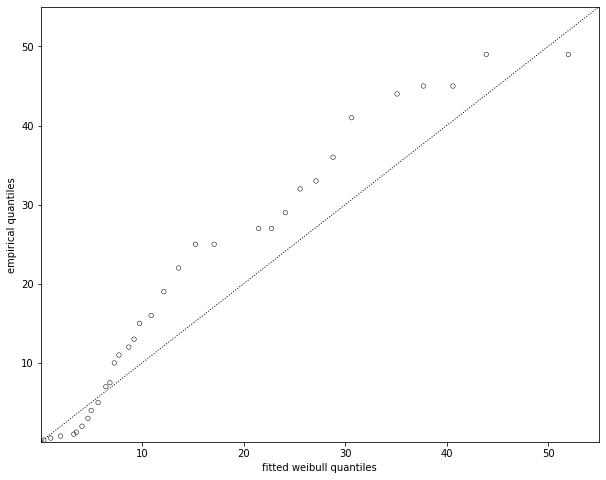

In [78]:
# Goodness of fit
qq_plot(wb)

The data doesn't seem to fit perfectly the Weibull survival function, but this is something expectable as we don't have enough sample. <br>
We can plot the summary with all the coefficients for further information.

In [79]:
aft = WeibullAFTFitter().fit(heart_patients, duration_col='survival', event_col='event')

# Print the summary
print(aft.summary)

                                   coef     exp(coef)     se(coef)  \
param   covariate                                                    
lambda_ age                   -0.022558  9.776943e-01     0.020226   
        alive                 25.940048  1.843400e+11  6337.269404   
        epss                  -0.059058  9.426518e-01     0.027445   
        fractionalshortening   0.514036  1.672026e+00     1.537273   
        lvdd                  -0.066594  9.355750e-01     0.266387   
        pericardialeffusion   -0.515951  5.969329e-01     0.380575   
        wallmotion_index      -0.876283  4.163275e-01     0.476869   
        wallmotion_score      -0.006986  9.930384e-01     0.041706   
        Intercept              6.430699  6.206078e+02     1.773161   
rho_    Intercept             -0.274215  7.601687e-01     0.093018   

                              coef lower 95%  coef upper 95%  \
param   covariate                                              
lambda_ age                    

EPSS and the intercept of the model are the only statistically significant coefficients of the model, followed by wall motion index even though it wasn't statistically significant in this dataset. <br>
Now we can take this analysis one step further and quantify how much important EPSS is to the model.

In [80]:
# Calculate the exponential of EPSS coefficient
# A unit increase in covariate_i means the average survival time changes by a factor of np.exp(coefficient_i)
exp_epss = np.exp(aft.params_.loc['lambda_'].loc['epss'])
print('When EPSS increases by one unt, the average survival duration changes by a factor of ', round(exp_epss, 3), '; approximately a 6.3% decrease in mean/median.', sep='')

When EPSS increases by one unt, the average survival duration changes by a factor of 0.943; approximately a 6.3% decrease in mean/median.


We can refit the model using only the parameters that were impactful to have a better adjusted model.

In [81]:
aft = WeibullAFTFitter()

# Fit custom model
aft.fit(heart_patients, 
        duration_col='survival', 
        event_col='event',
        formula='epss + pericardialeffusion + wallmotion_index')

# Print model summary
print(aft.summary)

                                 coef  exp(coef)  se(coef)  coef lower 95%  \
param   covariate                                                            
lambda_ Intercept            4.594673  98.955755  0.515098        3.585099   
        epss                -0.041971   0.958898  0.024288       -0.089574   
        pericardialeffusion -0.528558   0.589455  0.362944       -1.239916   
        wallmotion_index    -0.795242   0.451472  0.340189       -1.462001   
rho_    Intercept           -0.234934   0.790623  0.091938       -0.415130   

                             coef upper 95%  exp(coef) lower 95%  \
param   covariate                                                  
lambda_ Intercept                  5.604246            36.056934   
        epss                       0.005633             0.914320   
        pericardialeffusion        0.182800             0.289409   
        wallmotion_index          -0.128484             0.231772   
rho_    Intercept                 -0.054738  

<br>
<br>
<br>

### Prediction 
<br>
The next step is to analyze the impact of the main variables in the model. We can plot partial effects of a specific covariate to the model to get an overview of how it alters the survival curve.

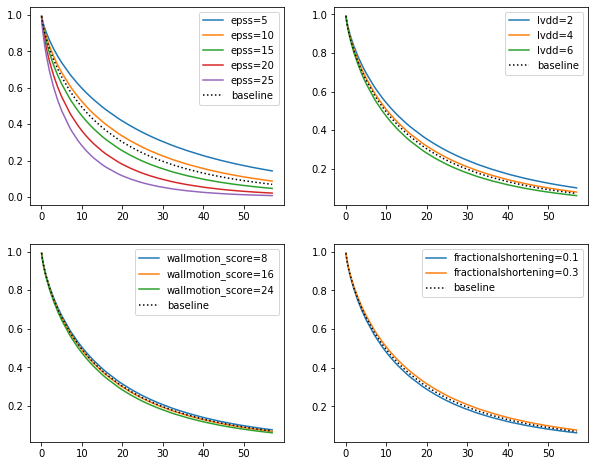

In [82]:
aft.fit(df=heart_patients,
        duration_col='survival',
        event_col='event')

fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax1 = aft.plot_partial_effects_on_outcome(covariates='epss', values=[5, 10, 15, 20, 25])

ax2 = fig.add_subplot(2, 2, 2)
ax2 = aft.plot_partial_effects_on_outcome(covariates='lvdd', values=[2, 4, 6])

ax3 = fig.add_subplot(2, 2, 3)
ax3 = aft.plot_partial_effects_on_outcome(covariates='wallmotion_score', values=[8, 16, 24])

ax4 = fig.add_subplot(2, 2, 4)
ax4 = aft.plot_partial_effects_on_outcome(covariates='fractionalshortening', values=[.1, .3])

EPSS was the variable with the lowest p-value and here we can see how much it can affect the survival function. Each line depicts a scenario were the target variable is equal to the value in the legend (which were selected randomly based on the raw data).
<br><br><br>

### Other models 

Alternatively, we can try fitting the data to other survival models and see if some of them can fit better the data. <br>
There are two things we can do to test this: 
1. Plot the QQ-plot for each model and choose the one that overlaps with the underlying distribution.
2. Select the model with the lowest AIC score. 

C:\ProgramData\Anaconda3\lib\site-packages\lifelines\fitters\__init__.py:985: ApproximationWarning: 
The Hessian for PiecewiseExponentialFitter's fit was not invertible. We will instead approximate it using the pseudo-inverse.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too. Perform plots of the cumulative hazard to help understand the latter's bias.

  warnings.warn(warning_text, exceptions.ApproximationWarning)


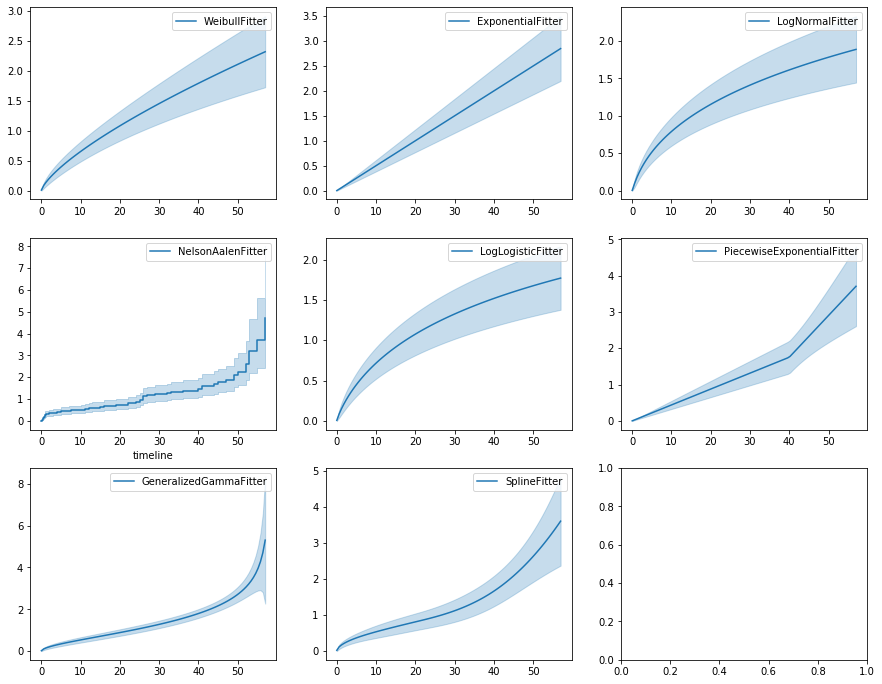

In [83]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

T = heart_patients['survival']
E = heart_patients['event']
models_ = []

models_.append(WeibullFitter().fit(T, E, label='WeibullFitter'))
models_.append(ExponentialFitter().fit(T, E, label='ExponentialFitter'))
models_.append(LogNormalFitter().fit(T, E, label='LogNormalFitter'))
models_.append(NelsonAalenFitter().fit(T, E, label='NelsonAalenFitter'))
models_.append(LogLogisticFitter().fit(T, E, label='LogLogisticFitter'))
models_.append(PiecewiseExponentialFitter([40, 60]).fit(T, E, label='PiecewiseExponentialFitter'))
models_.append(GeneralizedGammaFitter().fit(T, E, label='GeneralizedGammaFitter'))
models_.append(SplineFitter([6, 20, 40, 75]).fit(T, E, label='SplineFitter'))

idx = 0
k = 3
while idx < len(models_):
    models_[idx].plot_cumulative_hazard(ax=axes[idx//k][idx%k])
    idx += 1

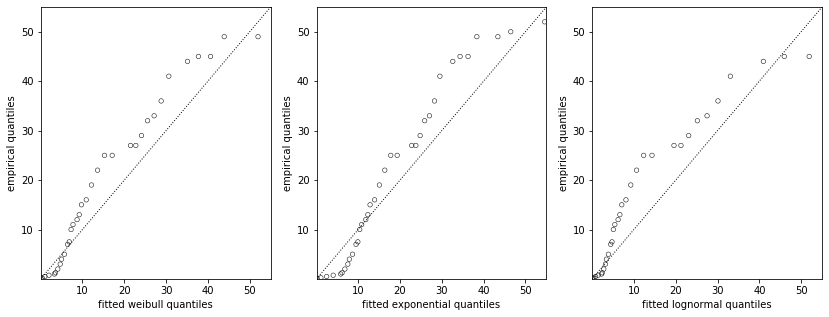

In [84]:
## QQ-plot
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
idx = 0
while idx < 3:
    if idx==3:
        idx += 1
        continue
    else:
        qq_plot(models_[idx], ax=axes[idx])
        idx += 1

In [85]:
# AIC scores
wb = WeibullFitter()
exp = ExponentialFitter()
log = LogNormalFitter()
llf = LogLogisticFitter()
pwf = PiecewiseExponentialFitter([40, 60])
gg = GeneralizedGammaFitter()
spf = SplineFitter([6, 20, 40, 75])

# Fit to data
for model in (wb, exp, log, llf, pwf, gg, spf):
    model.fit(durations=heart_patients['survival'],
            event_observed=heart_patients['event'])
    # Print AIC
    print(model.__class__.__name__, model.AIC_)

WeibullFitter 582.5024793380239
ExponentialFitter 593.4463559391629
LogNormalFitter 595.2991351107916
LogLogisticFitter 599.5675744094729


C:\ProgramData\Anaconda3\lib\site-packages\lifelines\fitters\__init__.py:985: ApproximationWarning: 
The Hessian for PiecewiseExponentialFitter's fit was not invertible. We will instead approximate it using the pseudo-inverse.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too. Perform plots of the cumulative hazard to help understand the latter's bias.

  warnings.warn(warning_text, exceptions.ApproximationWarning)


PiecewiseExponentialFitter 588.6874115531773
GeneralizedGammaFitter 558.5394634942649
SplineFitter 563.8509859565897


Generalized Gamma and Spline Fitter outperformed the Weibull function, so these are candidates we should keep working with in a future analysis. 

### Cox PH

Now we will fit a Cox PH model. This method implements a Cox Proportional Hazards model for survival regression that models the baseline hazard function and hazard ratios that define hazard proportions. <br>
This model describes the probability that event happens at some time, given survival up to that time, or $h(t)$. <br>
The hazard rate is the instantaneous rate of event occuring <br><br>
$\Large H(t) =  \int_0^t \lambda(z) \;dz$
<br><br>
And the estimator for this quantity is called the Nelson Aalen estimator: <br><br>
$\Large \hat{H}(t) = \sum_{t_i \le t} \frac{d_i}{n_i}$
<br><br> Where $d_i$ is the number of deats at time $t_i$ and $n_i$ the number of susceptible individuals. Now let's try to build the model. 

In [86]:
# Instantiate CoxPHFitter class cph
cph = CoxPHFitter().fit(df=heart_patients, duration_col="survival", event_col="event")

# print summary
cph.print_summary()

C:\ProgramData\Anaconda3\lib\site-packages\lifelines\utils\__init__.py:1123: ConvergenceWarning: Column alive have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event'].astype(bool)
>>> print(df.loc[events, 'alive'].var())
>>> print(df.loc[~events, 'alive'].var())

A very low variance means that the column alive completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\lifelines\fitters\coxph_fitter.py:1597: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.423. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in th

<lifelines.CoxPHFitter: fitted with 96 total observations, 22 right-censored observations>
             duration col = 'survival'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 96
number of events observed = 74
   partial log-likelihood = -239.88
         time fit was run = 2022-03-22 01:57:36 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
alive                -18.48       0.00    2630.29         -5173.75          5136.80                 0.00                  inf
age                    0.02       1.02       0.02            -0.01             0.05                 0.99                 1.05
pericardialeffusion    0.41       1.50       0.29            -0.16             0.98                 0.85                 2.67
fractionalshortening  -0.69       0.50       1.23            -3.10             1.72                 0.04                 5.59
epss                   0.05       1.05       0.02             0.01             0.09                 1.01                 1.10
lvdd                   0.01       1.01       0.21            -0.40             0.41                 0.67                 1.51
wallmotion_score      -0.01       0.99       0.03            -0.07             0.05                 0.93                 1.05
wallmotion_index       0.46       1.58       0.36            -0.25             1.17                 0.78                 3.22

                         z    p   -log2(p)
covariate                                 
alive                -0.01 0.99       0.01
age                   1.17 0.24       2.05
pericardialeffusion   1.40 0.16       2.63
fractionalshortening -0.56 0.57       0.80
epss                  2.25 0.02       5.37
lvdd                  0.03 0.98       0.04
wallmotion_score     -0.23 0.82       0.29
wallmotion_index      1.26 0.21       2.27
---
Concordance = 0.73
Partial AIC = 495.76
log-likelihood ratio test = 34.37 on 8 df
-log2(p) of ll-ratio test = 14.81

EPSS was the only statistically significant variable, but more data is required. As in previous models pericardial efussion and wall motion index could become significant with a bigger sample. \n
Let's refit the model taking only these three variables.

In [87]:
# Fit cph to data
cph = CoxPHFitter().fit(df=heart_patients, duration_col="survival", event_col="event", formula="epss + pericardialeffusion + wallmotion_index")

# Print model summary
print(cph.summary)

                         coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                            
epss                 0.039771   1.040572  0.019834        0.000898   
pericardialeffusion  0.402849   1.496081  0.289452       -0.164466   
wallmotion_index     0.335405   1.398506  0.271562       -0.196847   

                     coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
epss                       0.078644             1.000898             1.081819   
pericardialeffusion        0.970165             0.848346             2.638380   
wallmotion_index           0.867657             0.821316             2.381324   

                            z         p  -log2(p)  
covariate                                          
epss                 2.005229  0.044939  4.475904  
pericardialeffusion  1.391765  0.163994  2.608289  
wallmotion_index     1.235094  0.21

Variables in this model have a lower significance compared to the previous example. We can now use the coefficients to look into the importance of each one. Let's see EPSS as we did in the previous model. 

In [88]:
# Assign summary to summary_df
summary_df = cph.summary

# Create new column of survival time ratios
summary_df["surv_ratio"] = 1 / summary_df['exp(coef)']

# Print surv_ratio 
print(summary_df.loc['epss', "surv_ratio"])

0.9610095633887139


Using the same formula we used for the Weibull model, we can conclude that with a one-unit increase in EPSS, survival time decreases by 3.9%.

We can make predictions too using the Cox PH survival function. The values of the samples we want to predict go into the values parameter, and by doing this we can display the partial effects by sample. <br>
The two examples we picked are actually real data points we left aside at the beginning of the analysis as a small validation set. The first value belongs to a patient that survived while the second belongs to a patient who died in a few weeks.

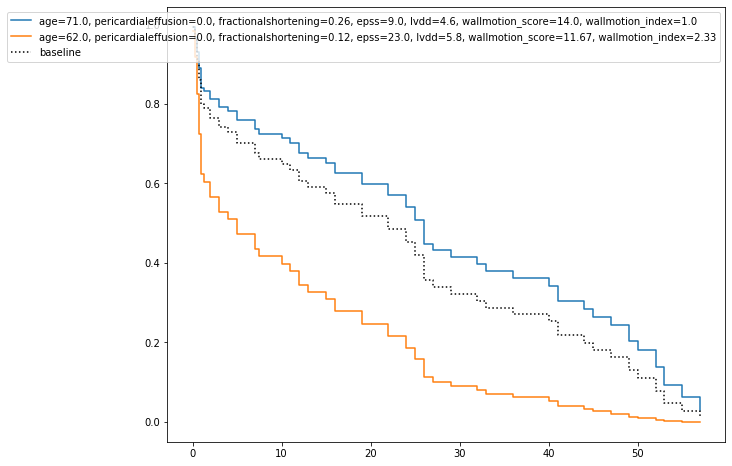

In [89]:
# The first value survived whereas the second died the first month
# Plot partial effects
cph.plot_partial_effects_on_outcome(covariates=['age', 'pericardialeffusion', 'fractionalshortening', 'epss', 'lvdd', 'wallmotion_score', 'wallmotion_index'],
         values=[[71, 0, 0.26, 9, 4.6, 14, 1],
                 [62, 0, 0.12, 23, 5.8, 11.67, 2.33]])

# Show plot
plt.show()

But before jumping to conclusions, there is an assumption that data needs to meet, and that's the proportional hazards assumption. According to this, all individuals' hazards need to be proportional to one another. The major implication of this is that, as we can observe in the previous plot, there is a baseline hazard function and other hazards are specified with scaling factors. The other implication is that the relative survival impact associated with a variable does not change with time, so it is time-invariant. <br>
We can check if this assumption is met doing a quick health check:

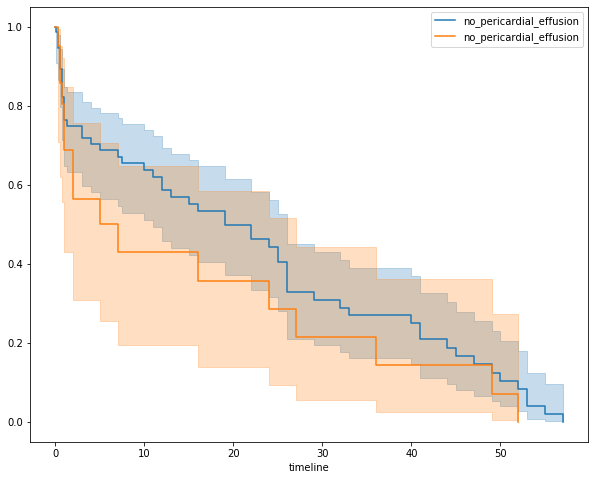

In [90]:
def PH_health_check(file:pd.DataFrame(), col:str):

    kmf.fit(durations=file[file[col] == 0]["survival"], 
            event_observed=file[file[col] == 0]["event"])
    ax = kmf.plot()

    kmf.fit(durations=file[file[col] == 1]["survival"],
            event_observed=file[file[col] == 1]["event"])
    ax = kmf.plot(ax=ax)
    plt.show()

PH_health_check(heart_patients, 'pericardialeffusion')

We can conclude that the assumption is met since there is a significant overlap between confidence intervals, but we can use a significance test method from the lifelines library to double check. 

In [91]:
print(cph.check_assumptions(training_df=heart_patients, p_value_threshold=0.1))

The ``p_value_threshold`` is set at 0.1. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 96 total observations, 22 right-censored observations>
         test_name = proportional_hazard_test

---
                          test_statistic    p  -log2(p)
epss                km              0.28 0.59      0.75
                    rank            0.28 0.60      0.74
pericardialeffusion km              0.02 0.90      0.15
                    rank            0.04 0.83      0.26
wallmotion_index    km              4.37 0.04      4.77
                    rank            4.43 0.04      4.82



1. Variable 'wallmotion_index' failed the non-proportional test: p-value is 0.0353.

   Advice 1: the functional form of the variable 'wallmotion_index' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'wallmotion_index' using pd.cut, and then specify it in
`strata=['wallmotion_index', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proporti

As specified in the summary, the variable wall motion index showed statistically significant differences and there are some things we can try to fix this as suggested in the description. In any case, meeting the proportional hazard assumption is often don't even required, first because with large datasets some degree of violation always show up, and second because if the goal is survival prediction the assumption is not important. We leave the decision of fixing this for futures analyses. 

### Predict with Cox PH

Using again the Cox PH model, we can plot the expected survival function for the patients that were alive at the end of the observation. For this analysis we will plot the survival function for the subset of patients.

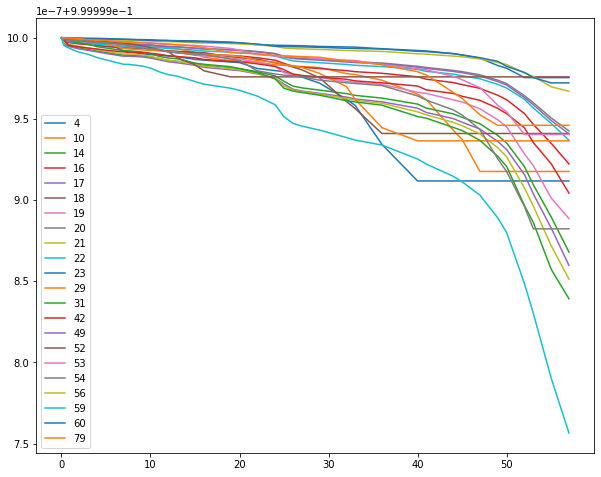

In [92]:
# Instantiate a new CoxPHFitter object and fit cph on all covariates
cph = CoxPHFitter().fit(heart_patients, 'survival', event_col='event')

# Select patients that are still alive
current_patients = heart_patients.loc[heart_patients['alive'] == 1]

# Existing durations of patients that are still alive
current_patients_last_obs = current_patients['survival']

# We want to know the more likely time a patient could pass on.
cph.predict_survival_function(X=current_patients, 
                              conditional_after=current_patients_last_obs).plot()  # conditional_after: time the subjects have already lived